The answer I am trying to answer is: Can we forcast the global temperature using only past temperature? For this purpose I use ARIMA and SARIMA to forcarst values of temperatures.

The data comes from the Berkeley Earth, which is affiliated with Lawrence Berkeley National Laboratory. Data obtained from https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/home/veroastro/Documents/earth_temperature/data/GlobalTemperatures.csv')
data.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.dtypes

dt                                            object
LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

In [4]:
#changing the date column,dt, into a datetime object
data['dt']=pd.to_datetime(data['dt'])
data.dtypes

dt                                           datetime64[ns]
LandAverageTemperature                              float64
LandAverageTemperatureUncertainty                   float64
LandMaxTemperature                                  float64
LandMaxTemperatureUncertainty                       float64
LandMinTemperature                                  float64
LandMinTemperatureUncertainty                       float64
LandAndOceanAverageTemperature                      float64
LandAndOceanAverageTemperatureUncertainty           float64
dtype: object

In [5]:
data.isna().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [6]:
cols = ['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']
land_avg_temp = data[cols].dropna()
land_avg_temp.isna().sum()

dt                                   0
LandAverageTemperature               0
LandAverageTemperatureUncertainty    0
dtype: int64

In [7]:
# creating the dataset of temperatures by year
land_avg_temp['years'] = pd.DatetimeIndex(land_avg_temp['dt']).year 
yearly = land_avg_temp.groupby('years').mean()
print(yearly.describe())
avg_temp = yearly['LandAverageTemperature']
avg_temp.shape

       LandAverageTemperature  LandAverageTemperatureUncertainty
count              266.000000                         266.000000
mean                 8.369337                           0.945719
std                  0.584921                           0.994110
min                  5.779833                           0.062083
25%                  8.081563                           0.210208
50%                  8.372167                           0.405583
75%                  8.704167                           1.629563
max                  9.831000                           4.026000


(266,)

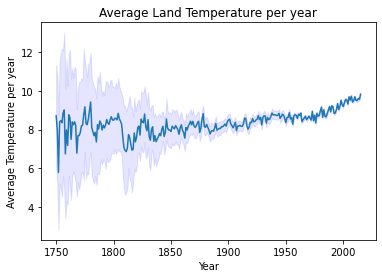

In [8]:
y = yearly['LandAverageTemperature']
unc = yearly['LandAverageTemperatureUncertainty']
yearly.index
plt.plot(y)
plt.fill_between(yearly.index,y+unc,y-unc,alpha=0.1, color='b' )
plt.title("Average Land Temperature per year")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.show()

In [9]:
# splitting the dataset into train and test datasets
size = len(avg_temp)
cutoff = int(size*0.7)
train = avg_temp[100:cutoff]
test = avg_temp[cutoff:]
print('train:', train.shape)
print('test:', test.shape)

train: (86,)
test: (80,)


We start the count of the training dataset at 100 because of the big uncertainty and variation of the first 100 years of the dataset. The model predictions dont match the increasing trend in average temperatures. So the data we use is from 1850 instead of 1750.

In [10]:
from pmdarima.arima.stationarity import ADFTest


# Test whether we should difference at the alpha=0.05 significance level
adf_test = ADFTest(alpha=0.05)
p_val_all, should_diff_all= adf_test.should_diff(avg_temp)  # (0.01, False)
adf_test = ADFTest(alpha=0.05)
p_val_red, should_diff_red= adf_test.should_diff(avg_temp[100:]) 
print('pval all', p_val_all)
print(should_diff_all)
print('pval reduce 100', p_val_red)
print(should_diff_red)

pval 0.03493678882214066
False


Eliminating the first 100 years changes the p-value from 0.03 to 0.4 which changes the need to difference it becauset the time series becomes non-stationary.

## Using Arima

In [11]:
#!pip3 install pmdarima
import pmdarima as pm

# auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec


/home/veroastro/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.180, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.476, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25.585, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.087, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-32.613, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-32.198, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.978 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  20.306
Date:                Sat, 26 Mar 2022   AIC                            -32.613
Time:                        18:42:04   BIC                            -22.842
Sample:                             0   HQIC                           -28.683
                                 - 86                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0061      0.003      2.297      0.022       0.001       0.011
ma.L1         -0.5535      0.109     -5.100      0.000      -0.766      -0.341
ma.L2         -0.3419      0.120     -2.861      0.004      -0.576      -0.108
sigma2         0.0357      0.006      5.851      0.000       0.024       0.048
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.63   Prob(JB):                         0.66
Heteroskedasticity (H):               0.58   Skew:                            -0.18
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

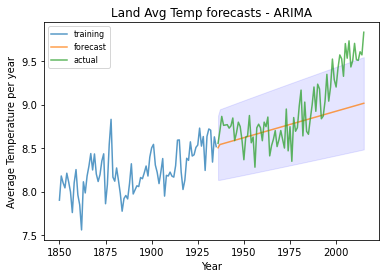

In [12]:
# Forecast
preds, conf_int = smodel.predict(n_periods=test.shape[0], return_conf_int=True)

# plot the prediction and the actual test values
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1850  # Year starts at 1850

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75, label='training')
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75, label='forecast')  # Forecasts
plt.plot(x_years[x_axis[train.shape[0]:]], test,alpha=0.75, label='actual')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Land Avg Temp forecasts - ARIMA")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
#Calculate the mean absolute percentage
mape = np.mean(np.abs(preds - test)/np.abs(test))
print((1-mape)*100) #print mape as an accuracy percentage

97.25245502336743


## Using SARIMA 
Adding seasonality to the model.

In [14]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=42.701, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=25.384, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=37.766, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16.928, Time=0.19 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=21.181, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=10.591, Time=0.27 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=18.045, Time=0.14 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-1.267, Time=0.39 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=6.255, Time=0.11 sec
 

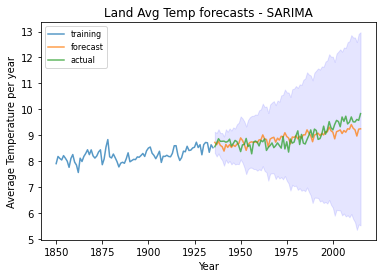

In [15]:
# Forecast
preds, conf_int = smodel.predict(n_periods=test.shape[0], return_conf_int=True)

# plot the prediction and the actual test values
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1850  # Year starts at 1850

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75, label='training')
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75, label='forecast')  # Forecasts
plt.plot(x_years[x_axis[train.shape[0]:]], test,alpha=0.75, label='actual')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Land Avg Temp forecasts - SARIMA")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
#Calculate the mean absolute percentage
mape = np.mean(np.abs(preds - test)/np.abs(test))
print((1-mape)*100) #print mape as an accuracy percentage

97.39195771731377


Using the Mean Absolute Percentage Error (MAPE), we have a 97.4% accuracy of the SARIMA model. Even if the mape of the ARIMA and SARIMA model are similar(97.4 and 97.2), from the images SARIMA seems to be doing a better job.  Looking at the image above it seems it under forcast the values of actual temperature after about the year 2000. 